In [1]:
import csv
import os

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42

In [2]:
static_csv_path = os.path.join(os.getcwd(), 'models/static_gesture/data/gesture.csv')
static_classifier_path = os.path.join(os.getcwd(), 'models/static_gesture/static_classifier.keras')
static_tflite_path = os.path.join(os.getcwd(), 'models/static_gesture/static_classifier.tflite')

In [3]:
def generate_model(X_train, X_test, y_train, y_test, num_classes):

    num_features = X_train.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input((num_features, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    cp_callback = tf.keras.callbacks.ModelCheckpoint(static_classifier_path, verbose=1, save_weights_only=False)
    # es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    
    # Train the model 
    model.fit(X_train, 
              y_train,
              validation_data=(X_test, y_test),
              callbacks=[cp_callback],
              epochs=200, 
              batch_size=1)


    
    return model
    

In [4]:
# X_lim represents 21 hand landmarks with X,Y coords (therefore x2) and one handedness column
X_lim = 1 + (21 * 2)
X_range = range(1, X_lim + 1)

X = np.loadtxt(static_csv_path, delimiter=',', dtype='float32', usecols=list(X_range))

y = np.loadtxt(static_csv_path, delimiter=',', dtype='float32', usecols=(0)).astype(np.int64)

In [5]:
#not enough data yet for stratified kfold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# encode target variables for classification
ohe = OneHotEncoder(handle_unknown='ignore')

ohe = ohe.fit(y_train.reshape(-1, 1))

y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

num_classes = len(ohe.categories_[0])

In [6]:
m = generate_model(X_train, X_test, y_train, y_test, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 43)                0         
                                                                 
 dense (Dense)               (None, 20)                880       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1123 (4.39 KB)
Trainable params: 1123 (4.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
1176/1224 [=

In [7]:
# Model evaluation
val_loss, val_acc = m.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 2ms/step - loss: 0.0150 - accuracy: 1.0000


In [8]:
# Load saved model
model = tf.keras.models.load_model(static_classifier_path)

In [9]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 67ms/step
[2.5076457e-05 1.0068550e-05 9.9996483e-01]
2


10/10 [==============================] - 0s 888us/step


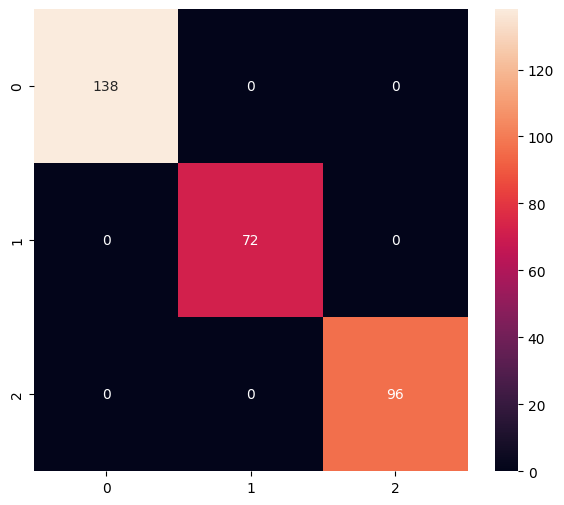

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00        72
           2       1.00      1.00      1.00        96

    accuracy                           1.00       306
   macro avg       1.00      1.00      1.00       306
weighted avg       1.00      1.00      1.00       306



In [10]:
def display_confusion_matrix(y_true, y_pred, report=True): 
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

y_pred

display_confusion_matrix(ohe.inverse_transform(y_test).flatten(), y_pred)

In [11]:
# Save model
model.save(static_classifier_path)

In [12]:
# Transform model to tflite

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(static_tflite_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\MICKEY~1\AppData\Local\Temp\tmp6d3lko6z\assets


INFO:tensorflow:Assets written to: C:\Users\MICKEY~1\AppData\Local\Temp\tmp6d3lko6z\assets


6580

In [13]:
interpreter = tf.lite.Interpreter(model_path=static_tflite_path)
interpreter.allocate_tensors()

In [14]:
# Get input & output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [15]:
%%time
# Inference 
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 31.2 ms
Wall time: 2 ms


In [16]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[nan nan nan]
0
